In [0]:
import math
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn import preprocessing
from sklearn import impute
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', titlesize=20)
import io
from google.colab import files

# Business Understanding

Obesity is a condition defined by the [World Health Organization](https://www.who.int/topics/obesity/en/) as a "major risk factor for a number of chronic diseases, including diabetes, cardiovascular diseases and cancer" and a leading preventable cause of death in the United States and worldwide. It is also a condition that is seen increasingly in children. The [Youth Risk Behavior Surveillance System (YRBSS)](https://www.cdc.gov/healthyyouth/data/yrbs/overview.htm) was developed in 1990 by the Centers for Disease Control and Prevention (CDC) to study obesity and other health outcomes and associated risk factors among youth in the United States. The motivation for this project is to understand the rates of youth obesity over time and across locations and populations within the United States, and how they are correlated with certain nutritional, behavioral, institutional, and environmental risk factors.

Two datasets from the CDC are considered in this project: [Nutrition, Physical Activity, and Obesity - Youth Risk Behavior Surveillance System](https://chronicdata.cdc.gov/Nutrition-Physical-Activity-and-Obesity/Nutrition-Physical-Activity-and-Obesity-Youth-Risk/vba9-s8jp) contains information on the prevalence of youth obesity and associated risk factors gathered from the YRBSS, and [Nutrition, Physical Activity, and Obesity - Policy and Environmental Data](https://data.cdc.gov/Nutrition-Physical-Activity-and-Obesity/Nutrition-Physical-Activity-and-Obesity-Policy-and/k8w5-7ju6) focuses on state policy and environmental factors. The objective is to identify the possible interventions that governments, the private sector, and individuals can work toward that have the greatest potential for a positive impact on health outcomes.

# Question 1: How do obesity rates vary over time and by population?

### Data Understanding

Let's upload the first dataset and take a look at what it contains.

In [0]:
obesity = pd.read_csv('Youth_Risk_Behavior_Surveillance_System.csv')
obesity.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,Datasource,Class,Topic,Question,Data_Value_Unit,Data_Value_Type,Data_Value,Data_Value_Alt,Data_Value_Footnote_Symbol,Data_Value_Footnote,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,Total,Gender,Grade,Race/Ethnicity,GeoLocation,ClassID,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2013,2013,NH,New Hampshire,Youth Risk Behavior Surveillance System,Fruits and Vegetables,Fruits and Vegetables - Behavior,Percent of students in grades 9-12 who consume...,NaN,Value,NaN,NaN,~,Data not available because sample size is insu...,NaN,NaN,NaN,NaN,NaN,NaN,American Indian/Alaska Native,"(43.655950113, -71.50036092)",FV,FV1,Q020,VALUE,33,Race/Ethnicity,American Indian/Alaska Native,RACE,RACENAA
1,2009,2009,PA,Pennsylvania,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have an...,NaN,Value,14.4,14.4,NaN,NaN,10.2,19.9,215,NaN,NaN,NaN,Non-Hispanic Black,"(40.793730152, -77.860700294)",OWS,OWS1,Q039,VALUE,42,Race/Ethnicity,Non-Hispanic Black,RACE,RACEBLK
2,2011,2011,RI,Rhode Island,Youth Risk Behavior Surveillance System,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who partici...,NaN,Value,NaN,NaN,~,Data not available because sample size is insu...,NaN,NaN,NaN,NaN,NaN,NaN,Hawaiian/Pacific Islander,"(41.708280193, -71.522470314)",PA,PA1,Q049,VALUE,44,Race/Ethnicity,Hawaiian/Pacific Islander,RACE,RACEHPI
3,2001,2001,ME,Maine,Youth Risk Behavior Surveillance System,Fruits and Vegetables,Fruits and Vegetables - Behavior,Percent of students in grades 9-12 who consume...,NaN,Value,25.5,25.5,NaN,NaN,22.9,28.3,"1,098",NaN,NaN,NaN,Non-Hispanic White,"(45.254228894001, -68.985031336)",FV,FV1,Q021,VALUE,23,Race/Ethnicity,Non-Hispanic White,RACE,RACEWHT
4,2009,2009,GA,Georgia,Youth Risk Behavior Surveillance System,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who partici...,NaN,Value,25.2,25.2,NaN,NaN,11.1,47.6,167,NaN,NaN,NaN,Hispanic,"(32.839681093, -83.627580346)",PA,PA1,Q049,VALUE,13,Race/Ethnicity,Hispanic,RACE,RACEHIS


At first glance we can see that this dataset contains information from survey questions conducted across various years, states, and population groups. It also contains many redundant columns, and some in which we simply aren't interested.

The data in the **Value** and **SampleSize** columns both appear to be numeric, but let's check to make sure.

In [0]:
obesity.Data_Value.iloc[1]

14.4

In [0]:
obesity.Sample_Size.iloc[1]

'215'

We can see that the **Value** column is truly numeric, but the **SampleSize** column contains numbers formatted as strings. In order to utilize this data, we will need to fix this.

The preview also makes it difficult to see what questions were asked in the surveys. Let's take a closer look.

In [0]:
obesity.Question.unique()

array(['Percent of students in grades 9-12 who consume fruit less than 1 time daily',
       'Percent of students in grades 9-12 who have an overweight classification',
       'Percent of students in grades 9-12 who participate in daily physical education',
       'Percent of students in grades 9-12 who consume vegetables less than 1 time daily',
       'Percent of students in grades 9-12 who have obesity',
       'Percent of students in grades 9-12 watching 3 or more hours of television each school day',
       'Percent of students in grades 9-12 who drank regular soda/pop at least one time per day',
       'Percent of students in grades 9-12 who achieve 1 hour or more of moderate-and/or vigorous-intensity physical activity daily'],
      dtype=object)

The survey responses describe our metrics of interest, the percent of students in grades 9-12 who have an overweight classification and the percent of students in grades 9-12 who have obesity. They also describe the prevalence of the associated risk factors. We will need to separate these questions into their own columns in our dataset.

### Data Preparation

Our first task is to clean this dataset, making it easier to understand and work with. Many columns are identical or redundant to others, so we can drop them.

In [0]:
obesity.drop(columns=['YearEnd', 'LocationDesc', 'Datasource', 'Class',
                      'Topic', 'Data_Value_Unit', 'Data_Value_Type',
                      'Data_Value_Alt', 'Data_Value_Footnote_Symbol',
                      'Data_Value_Footnote', 'Low_Confidence_Limit',
                      'High_Confidence_Limit ', 'Total', 'Gender', 'Grade',
                      'Race/Ethnicity', 'GeoLocation', 'ClassID', 'TopicID',
                      'QuestionID', 'DataValueTypeID', 'LocationID',
                      'StratificationCategory1', 'StratificationCategoryId1',
                      'StratificationID1'], inplace=True)

Let's give the remaining columns more appropriate names.

In [0]:
obesity.rename(columns={'YearStart':'Year',
                        'LocationAbbr':'Location',
                        'Stratification1':'Group',
                        'Data_Value':'Value',
                        'Sample_Size':'SampleSize'}, inplace=True)
obesity.head()

,Year,Location,Question,Value,SampleSize,Group
0,2013,NH,Percent of students in grades 9-12 who consume...,NaN,NaN,American Indian/Alaska Native
1,2009,PA,Percent of students in grades 9-12 who have an...,14.4,215,Non-Hispanic Black
2,2011,RI,Percent of students in grades 9-12 who partici...,NaN,NaN,Hawaiian/Pacific Islander
3,2001,ME,Percent of students in grades 9-12 who consume...,25.5,"1,098",Non-Hispanic White
4,2009,GA,Percent of students in grades 9-12 who partici...,25.2,167,Hispanic


Now let's transform the **SampleSize** columns into truly numeric data.

In [0]:
obesity.SampleSize = obesity.SampleSize.apply(lambda x: pd.to_numeric(x.replace(',','')) if not pd.isnull(x) else x)
obesity.SampleSize.iloc[1]

215.0

For right now, let's just consider the questions pertaining to health outcomes (how many students are overweight or obese), not the associated risk factors. Let's also focus on the nationwide data first, rather than by state.

In [0]:
us_obesity = obesity[(obesity.Location == 'US') & (obesity.Question.isin([
    'Percent of students in grades 9-12 who have obesity',
    'Percent of students in grades 9-12 who have an overweight classification']
    ))]
us_obesity = us_obesity[['Year','Group','SampleSize','Question','Value']]
us_obesity.sort_values(by=['Year','Group','Question'], inplace=True)
us_obesity.reset_index(drop=True, inplace=True)
us_obesity.head()

,Year,Group,SampleSize,Question,Value
0,2001,10th,3086.0,Percent of students in grades 9-12 who have an...,13.6
1,2001,10th,3086.0,Percent of students in grades 9-12 who have ob...,10.8
2,2001,11th,3256.0,Percent of students in grades 9-12 who have an...,12.5
3,2001,11th,3256.0,Percent of students in grades 9-12 who have ob...,10.7
4,2001,12th,3161.0,Percent of students in grades 9-12 who have an...,11.8


Let's split those two questions into separate columns and rename them.

In [0]:
us_obesity = us_obesity.pivot_table(index=['Year', 'Group', 'SampleSize'],
                                    columns='Question', values = 'Value')
del us_obesity.columns.name
us_obesity.reset_index(inplace=True)
us_obesity.rename(columns={
    'Percent of students in grades 9-12 who have an overweight classification':'Overweight',
    'Percent of students in grades 9-12 who have obesity':'Obese'}, inplace=True)
us_obesity.head()

,Year,Group,SampleSize,Overweight,Obese
0,2001,10th,3086.0,13.6,10.8
1,2001,11th,3256.0,12.5,10.7
2,2001,12th,3161.0,11.8,9.6
3,2001,2 or more races,359.0,14.6,9.2
4,2001,9th,3091.0,15.7,10.4


One problem with the data is that the definition of "overweight" is not precisely what we are interested in tracking. The [survey documentation](https://www.cdc.gov/healthyyouth/data/yrbs/pdf/2017/2017_yrbs_sadc_documentation.pdf) (pages 61-62) defines **obese** as: "students who were >= 95th percentile for body mass index, based on sex- and age-specific reference data from the 2000 CDC growth charts", but **overweight** as: "students who were >= 85th percentile but <95th percentile for body mass index, based on sex- and age-specific reference data from the 2000 CDC growth charts".

This latter metric is not so straightforward to interpet. For example, would an increase in the percentage of overweight students be due to students with BMI previously below 85th percentile gaining weight, or those with BMI previously above 95th percentile losing weight? It would be unclear. Better would be a metric that, like obesity, captures all students above a certain BMI threshold.

Therefore, let us define the metric **overweight or obese** as the percentage of students with BMI >= 85th percentile. Since the categories of overweight and obese are mutually exclusive and directly adjacent on the BMI scale, we can add those percentages to calculate our new metric.

In [0]:
us_obesity['OverweightOrObese'] = us_obesity.Overweight+us_obesity.Obese
us_obesity.drop(columns="Overweight", inplace=True)
us_obesity.head()

,Year,Group,SampleSize,Obese,OverweightOrObese
0,2001,10th,3086.0,10.8,24.4
1,2001,11th,3256.0,10.7,23.2
2,2001,12th,3161.0,9.6,21.4
3,2001,2 or more races,359.0,9.2,23.8
4,2001,9th,3091.0,10.4,26.1


What are the relative sizes of some of our population groups? Let's average the sample sizes for the racial/ethnic groups across time to get an idea.

In [0]:
race_ethnicity_grouping = ['Non-Hispanic White', 'Non-Hispanic Black',
    'Hispanic', 'Asian', 'American Indian/Alaska Native',
    'Hawaiian/Pacific Islander', '2 or more races']
us_obesity[['Group','SampleSize']].groupby('Group').mean().loc[
    race_ethnicity_grouping].sort_values(by='SampleSize', ascending=False)

,SampleSize
Group,
Non-Hispanic White,5958.333333
Hispanic,3666.333333
Non-Hispanic Black,2598.333333
2 or more races,516.666667
Asian,470.333333
American Indian/Alaska Native,164.000000
Hawaiian/Pacific Islander,124.400000


Clearly some groups are larger and will influence the overall trends more. We may want to highlight this visually.

Finally, let's reformat the 9th grade strings so that they will appear first alphabetically.

In [0]:
us_obesity.Group = us_obesity.Group.apply(lambda x: x.replace('9',' 9'))

### Modeling

Let's take a look at how the percentages of students in the U.S. that were obese and overweight or obese has changed from 2001 to 2017, overall and for specific populations. It does't make much sense to compare obesity rates for populations of different types, e.g. 12th graders and males, so we will plot each separately. Let's use variable marker size to illustrate populations' relative sample sizes.

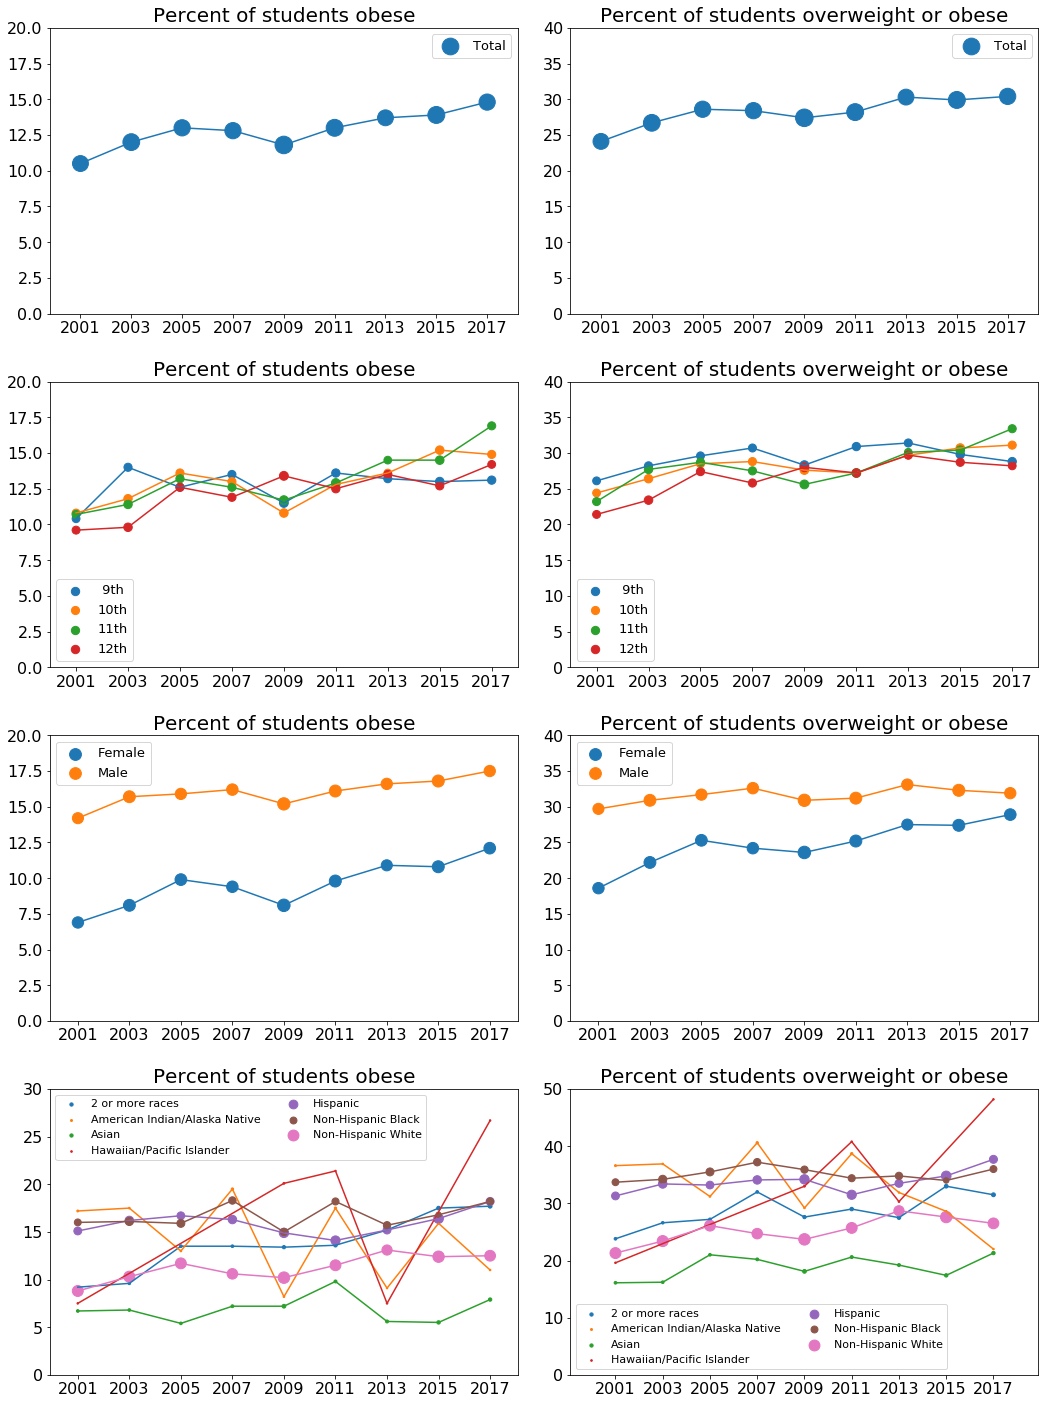

In [0]:
fig, axs = plt.subplots(4, 2, figsize=(15,20))
axs = axs.ravel()

total = ['Total']
grade_grouping = [' 9th', '10th', '11th', '12th']
gender_grouping = ['Male', 'Female']
race_ethnicity_grouping = ['Non-Hispanic White', 'Non-Hispanic Black',
    'Hispanic', 'Asian', 'American Indian/Alaska Native',
    'Hawaiian/Pacific Islander', '2 or more races']

for i, ax in enumerate(axs):
    grouping = [total,grade_grouping,gender_grouping,race_ethnicity_grouping][int(i/2)]
    us_obesity_by_group = us_obesity[us_obesity.Group.isin(grouping)]
    groups = us_obesity_by_group.groupby('Group')
    for name, group in groups:
        if i%2 == 0:
          ax.plot(group.Year, group.Obese, linestyle='-')
          ax.scatter(group.Year, group.Obese, s=group.SampleSize/50,
                     marker='o', linestyle='-', label=name)
          ax.set_title('Percent of students obese')
          ymax = 10*math.ceil(us_obesity_by_group.Obese.max()/10)
        else:
          ax.plot(group.Year, group.OverweightOrObese, linestyle='-')
          ax.scatter(group.Year, group.OverweightOrObese, s=group.SampleSize/50,
                     marker='o', linestyle='-', label=name)
          ax.set_title('Percent of students overweight or obese')
          ymax = 10*math.ceil(us_obesity_by_group.OverweightOrObese.max()/10)
        ax.set_xticks(us_obesity_by_group.Year.unique())
        ax.set_xticklabels(us_obesity_by_group.Year.unique())
        ax.set_ylim(0, ymax)
        if i <= 3:
          ax.legend(prop={'size': 13})
        elif i <= 5:
          ax.legend(prop={'size': 13}, loc='upper left')
        else:
          ax.legend(prop={'size': 11}, ncol=2)

plt.margins(0.1)
plt.tight_layout(2.5)
plt.show()

### Evaluation

There isn't much that we can say about the grade subgroups. They all basically follow the overall trend, with some switching of places throughout the years. The breakdown by gender is much more stark: males have significantly higher percentages than females for all years. However, the female obesity rates are catching up to the male rates. In fact, the increase in the percent of male students that are overweight or obese from 2001 to 2017 is negligible; the overall increase is almost entirely due to the female population.

Looking at the race/ethnicity breakdown, some populations' rates are significantly variable over time. Obesity rates among the American Indian/Alaska Native population are the highest in 2001 but the second-lowest in 2017; meanwhile, those of the Hawaiian/Pacific Islander population are second-lowest in 2001 but highest in 2017. The order of the rates of the other five population groups are more stable. In most years, the Non-Hispanic Black and Hispanic populations have the highest rates out of these five groups, followed by 2 or more races, Non-Hispanic White, and Asian. Obesity rates for the Asian population are the lowest every year.

This analysis of the nationwide data has answered our question of how obesity rates within specific populations have changed over time.

# Question 2: How do obesity rates vary over time and by location?

### Data Understanding

We have already taken steps to understand the dataset as a whole. Now let's take a look at how obesity rates vary between states. For this question we will ignore the population groups.

### Data Preparation

Let's select the overall state and territory data, split the columns by question, and calculate the **overweight or obese** metric as before.

In [0]:
state_obesity = obesity[~(obesity.Location == 'US') & (obesity.Group == 'Total') &
    (obesity.Question.isin(['Percent of students in grades 9-12 who have obesity',
    'Percent of students in grades 9-12 who have an overweight classification']
    ))]
state_obesity = state_obesity[['Year','Location','SampleSize','Question','Value']]
state_obesity = state_obesity.pivot_table(index=['Year', 'Location', 'SampleSize'],
                                    columns='Question', values = 'Value')
del state_obesity.columns.name
state_obesity.reset_index(inplace=True)
state_obesity.rename(columns={
    'Percent of students in grades 9-12 who have an overweight classification':'Overweight',
    'Percent of students in grades 9-12 who have obesity':'Obese'}, inplace=True)
state_obesity['OverweightOrObese'] = state_obesity.Overweight+state_obesity.Obese
state_obesity.drop(columns="Overweight", inplace=True)
state_obesity.head()

,Year,Location,SampleSize,Obese,OverweightOrObese
0,2001,AL,1526.0,12.3,27.4
1,2001,AR,1586.0,13.7,29.4
2,2001,DE,2664.0,10.7,25.5
3,2001,FL,3802.0,10.1,24.0
4,2001,ID,1672.0,7.2,17.8


Trying to visualize all 51 locations at once (47 states, three territories, and DC) will be infeasible. For easier interpretation, let's look specifically at the locations with highest and lowest obesity rates.

First, let's compare each location's rates to the national average for each specific year. That way, if a location only has data for certain years it will be taken into account.

In [0]:
us_obesity_total = us_obesity[us_obesity.Group == 'Total']
state_obesity_diff_from_us = (state_obesity.groupby(['Location','Year']).mean(
    )-us_obesity_total.groupby('Year').mean())[['Obese','OverweightOrObese']]
state_obesity_diff_from_us.head()

Obese  OverweightOrObese
Location Year                          
AK       2003   -1.0               -1.3
         2007   -1.8               -1.3
         2009    0.1               -1.2
         2011   -1.5               -2.3
         2013   -1.3               -4.2

Now we can take the average across all years for which a state has data.

In [0]:
state_mean_obesity = state_obesity_diff_from_us.reset_index().groupby(
    'Location').mean()[['Obese','OverweightOrObese']]
state_mean_obesity.head()

,Obese,OverweightOrObese
Location,,
AK,-0.928571,-1.242857
AL,2.257143,3.128571
AR,3.275000,4.150000
AZ,-1.612500,-3.125000
CA,-0.450000,-0.500000


Finally, we can sort the list to get the locations with highest and lowest obesity rates.

In [0]:
lowest_obesity = list(state_mean_obesity.sort_values(by='Obese').index[0:5])
lowest_obesity

['UT', 'CO', 'ID', 'MT', 'WY']

In [0]:
highest_obesity = list(state_mean_obesity.sort_values(
    by='Obese', ascending=False).index[0:5])
highest_obesity

['GU', 'MS', 'KY', 'TN', 'AR']

In [0]:
lowest_ovr_or_obesity = list(state_mean_obesity.sort_values(
    by='OverweightOrObese').index[0:5])
lowest_ovr_or_obesity

['UT', 'CO', 'WY', 'MT', 'ID']

In [0]:
highest_ovr_or_obesity = list(state_mean_obesity.sort_values(
    by='OverweightOrObese', ascending=False).index[0:5])
highest_ovr_or_obesity

['GU', 'TN', 'MS', 'LA', 'KY']

### Modeling

Now we should be able to plot trends over time with clarity.

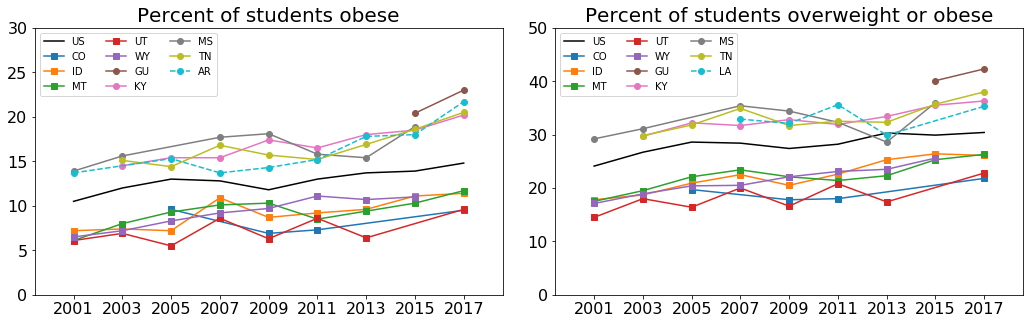

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(us_obesity_total.Year, us_obesity_total.Obese, 'k', label='US')
for name, group in state_obesity[state_obesity.Location.isin(lowest_obesity)].groupby('Location'):
    axs[0].plot(group.Year, group.Obese, '-s', label=name)
for name, group in state_obesity[state_obesity.Location.isin(highest_obesity) &
                                 state_obesity.Location.isin(highest_ovr_or_obesity)].groupby('Location'):
    axs[0].plot(group.Year, group.Obese, '-o', label=name)
for name, group in state_obesity[state_obesity.Location.isin(highest_obesity) &
                                 ~state_obesity.Location.isin(highest_ovr_or_obesity)].groupby('Location'):
    axs[0].plot(group.Year, group.Obese, '--o', label=name)
axs[0].margins(0.1)
axs[0].set_xticks(state_obesity.Year.unique())
axs[0].set_xticklabels(state_obesity.Year.unique())
axs[0].set_ylim(0, 10*math.ceil(state_obesity.Obese.max()/10))
axs[0].legend(loc='upper left',ncol=3)
axs[0].set_title('Percent of students obese')

axs[1].plot(us_obesity_total.Year, us_obesity_total.OverweightOrObese, 'k', label='US')
for name, group in state_obesity[state_obesity.Location.isin(lowest_ovr_or_obesity)].groupby('Location'):
    axs[1].plot(group.Year, group.OverweightOrObese, '-s', label=name)
for name, group in state_obesity[state_obesity.Location.isin(highest_ovr_or_obesity) &
                                 state_obesity.Location.isin(highest_obesity)].groupby('Location'):
    axs[1].plot(group.Year, group.OverweightOrObese, '-o', label=name)
for name, group in state_obesity[state_obesity.Location.isin(highest_ovr_or_obesity) &
                                 ~state_obesity.Location.isin(highest_obesity)].groupby('Location'):
    axs[1].plot(group.Year, group.OverweightOrObese, '--o', label=name)
axs[1].margins(0.1)
axs[1].set_xticks(state_obesity.Year.unique())
axs[1].set_xticklabels(state_obesity.Year.unique())
axs[1].set_ylim(0, 10*math.ceil(state_obesity.OverweightOrObese.max()/10))
axs[1].legend(loc='upper left',ncol=3)
axs[1].set_title('Percent of students overweight or obese')

plt.margins(0.1)
plt.tight_layout(2.5)
plt.show()

### Evaluation

The five locations with below-average obesity rates were Colorado, Idaho, Montana, Utah, and Wyoming, all located in the Rocky Mountains. The five with above-average rates were Guam, Kentucky, Mississippi, Tennessee, and either Arkansas (obesity) or Louisiana (overweightness or obesity). Besides Guam, these are all located along the Mississippi River. There was a fair amount of switching places between the locations in each group, but no switching between the groups. In fact, with the exception of 2013, none of these states ever crossed the U.S. average. It appears that geographic location may be strongly correlated with youth obesity.

Our analysis of the locations with the highest and lowest obesity rates and the resulting visualization convey the correlation between obesity rates and geography.

# Question 3: What nutritional, behavioral, institutional, and environmental factors are associated with obesity rates?

### Data Understanding

The obesity dataset contains nutritional and behavioral risk factors of interest to this project. However, we can also consider institutional and environmental factors from a second dataset.

In [0]:
policy = pd.read_csv('Policy_and_Environmental_Data.csv')
policy.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,Datasource,Class,Topic,Question,Data_Value_Unit,Data_Value_Type,Data_Value,Data_Value_Alt,Data_Value_Footnote_Symbol,Data_Value_Footnote,Total,GeoLocation,ClassID,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2014,2014,TX,Texas,Breastfeeding Surveillance Sources,Breastfeeding,Breastfeeding - Environmental or Policy Supports,"Number of La Leche League leaders per 1,000 li...",NaN,Value,0.5,0.5,NaN,NaN,Total,"(31.827240407, -99.426770206)",BF,BF2,Q014,VALUE,48,Total,Total,OVR,OVERALL
1,2013,2013,AR,Arkansas,ECE Surveillance Sources,Fruits and Vegetables,Fruits and Vegetables - Environmental or Polic...,State child care regulations align with nation...,NaN,Value,No,"10,002",NaN,NaN,Total,"(34.748650124, -92.274490743)",FV,FV2,Q032,VALUE,5,Total,Total,OVR,OVERALL
2,2012,2012,AZ,Arizona,ECE Surveillance Sources,Fruits and Vegetables,Fruits and Vegetables - Environmental or Polic...,State child care regulations align with nation...,NaN,Value,No,"10,002",NaN,NaN,Total,"(34.86597028, -111.763811277)",FV,FV2,Q033,VALUE,4,Total,Total,OVR,OVERALL
3,2012,2012,MI,Michigan,School Health Policies and Practices Study,Physical Activity,Physical Activity - Environmental or Policy Su...,State provides guidance on policies for school...,NaN,Value,No,"10,002",NaN,NaN,Total,"(44.661319543001, -84.71439027)",PA,PA2,Q054,VALUE,26,Total,Total,OVR,OVERALL
4,2010,2010,DE,Delaware,School Health Profiles (Profiles),Sugar Drinks,Sugar Drinks - Environmental or Policy Supports,Percent of secondary schools that allowed stud...,NaN,Value,34.4,34.4,NaN,NaN,Total,"(39.008830667, -75.577741168)",SD,SD2,Q063,VALUE,10,Total,Total,OVR,OVERALL


This dataset looks similar to the obesity dataset in that it contains the answers to various questions across states and years. One difference is the lack of a column for population groups; the data are simply statewide statistics. Let's take a look at the questions in this dataset to see which we want to consider.

In [0]:
policy.Question.unique()

array(['Number of La Leche League leaders per 1,000 live births',
       'State child care regulations align with national standards for serving fruits',
       'State child care regulations align with national standards for serving vegetables',
       'State provides guidance on policies for school districts or schools on joint-use agreements for physical activity facilities',
       'Percent of secondary schools that allowed students to purchase sports drinks from one or more vending machines or at the school store, canteen, or snack bar',
       'Number of International Board Certified Lactation Consultants (IBCLCs) per 1,000 live births',
       'Average Maternity Practice in Infant Nutrition and Care (mPINC) score among hospitals and birthing facilities',
       'Percent of live births occurring at facilities designated as "baby friendly" by the Baby Friendly Hospital Initiative (BFHI)',
       'State child care regulations align with national standards for moderate- to vigorous- 

Some refer to breastfeeding, another aspect of health studied by the surveys. Others apply to children significantly younger than the high school students we are considering. We will keep only the relevant questions.

In [0]:
policy.Data_Value.iloc[0]

'0.5'

In [0]:
policy.Data_Value.iloc[346]

'No'

Here we are dealing with the same issue of numbers formatted as strings, but with some genuine string values that we will need to maintain.

### Data Preparation

First let's separate all of the survey questions in the original obesity dataset.

In [0]:
obesity = obesity.drop(columns='SampleSize').pivot_table(index=['Year', 'Location', 'Group'], columns='Question')
obesity.columns = obesity.columns.get_level_values(1)
del obesity.columns.name
obesity.reset_index(inplace=True)
obesity.head()

,Year,Location,Group,Percent of students in grades 9-12 watching 3 or more hours of television each school day,Percent of students in grades 9-12 who achieve 1 hour or more of moderate-and/or vigorous-intensity physical activity daily,Percent of students in grades 9-12 who consume fruit less than 1 time daily,Percent of students in grades 9-12 who consume vegetables less than 1 time daily,Percent of students in grades 9-12 who drank regular soda/pop at least one time per day,Percent of students in grades 9-12 who have an overweight classification,Percent of students in grades 9-12 who have obesity,Percent of students in grades 9-12 who participate in daily physical education
0,2001,AL,10th,51.7,NaN,54.0,47.6,NaN,16.5,11.8,26.1
1,2001,AL,11th,42.6,NaN,56.4,43.7,NaN,12.5,10.1,26.8
2,2001,AL,12th,35.0,NaN,52.3,36.3,NaN,15.8,13.6,16.9
3,2001,AL,9th,51.3,NaN,52.7,52.8,NaN,15.3,13.1,50.6
4,2001,AL,Female,44.8,NaN,54.6,45.3,NaN,14.9,7.6,23.1


Let's give these columns shorter names and create the **overweight or obese** column.

In [0]:
obesity.rename(columns={'Percent of students in grades 9-12 watching 3 or more hours of television each school day':'TV',
                        'Percent of students in grades 9-12 who achieve 1 hour or more of moderate-and/or vigorous-intensity physical activity daily':'Exercise',
                        'Percent of students in grades 9-12 who consume fruit less than 1 time daily':'LackOfFruit',
                        'Percent of students in grades 9-12 who consume vegetables less than 1 time daily':'LackOfVeggies',
                        'Percent of students in grades 9-12 who drank regular soda/pop at least one time per day':'Soda',
                        'Percent of students in grades 9-12 who have an overweight classification':'Overweight',
                        'Percent of students in grades 9-12 who have obesity':'Obese',
                        'Percent of students in grades 9-12 who participate in daily physical education':'PhysEd'}, inplace=True)
obesity = obesity[['Year','Location','Group','TV','Exercise','PhysEd','LackOfFruit','LackOfVeggies','Soda','Overweight','Obese']]
obesity['OverweightOrObese'] = obesity.Overweight+obesity.Obese
obesity.drop(columns='Overweight', inplace=True)
obesity.head()

,Year,Location,Group,TV,Exercise,PhysEd,LackOfFruit,LackOfVeggies,Soda,Obese,OverweightOrObese
0,2001,AL,10th,51.7,NaN,26.1,54.0,47.6,NaN,11.8,28.3
1,2001,AL,11th,42.6,NaN,26.8,56.4,43.7,NaN,10.1,22.6
2,2001,AL,12th,35.0,NaN,16.9,52.3,36.3,NaN,13.6,29.4
3,2001,AL,9th,51.3,NaN,50.6,52.7,52.8,NaN,13.1,28.4
4,2001,AL,Female,44.8,NaN,23.1,54.6,45.3,NaN,7.6,22.5


The columns pertaining to fruit and vegetable consumption have been named **LackOfFruit** and **LackOfVeggies** to indicate that higher data values correspond to less fruit or vegetable consumption, in contrast to the other columns.

Now let's apply the same cleaning process to the policy dataset.

In [0]:
policy = policy[['YearStart','LocationAbbr','Question','Data_Value']]
policy.rename(columns={'YearStart':'Year','LocationAbbr':'Location','Data_Value':'Value'}, inplace=True)
policy.sort_values(by=['Year','Location'], inplace=True)
policy.reset_index(drop=True, inplace=True)
policy.head()

,Year,Location,Question,Value
0,2002,AK,State-level farm to school/preschool policy,Yes
1,2002,AL,State-level farm to school/preschool policy,No
2,2002,AR,State-level farm to school/preschool policy,No
3,2002,AZ,State-level farm to school/preschool policy,No
4,2002,CA,State-level farm to school/preschool policy,Yes


We can see that this dataset contains at least one year not present in the obesity dataset. Let's remove all the rows for which either the year or location don't match any of the obesity data.

In [0]:
policy = policy[(policy.Location.isin(obesity.Location.unique())) &
                (policy.Year.isin(obesity.Year.unique()))]
policy.reset_index(drop=True, inplace=True)
policy.head()

,Year,Location,Question,Value
0,2007,AK,Average Maternity Practice in Infant Nutrition...,73
1,2007,AK,Number of International Board Certified Lactat...,5.8
2,2007,AK,Percent of live births occurring at facilities...,0.0
3,2007,AL,Average Maternity Practice in Infant Nutrition...,55
4,2007,AL,Number of International Board Certified Lactat...,1.9


Now we can select the questions of interest and make all data values other than **Yes** and **No** numeric.

In [0]:
policy = policy[policy.Question.isin([
    'Number of farmers markets per 100,000 residents',
    'State child care regulations align with national standards for limiting total media time for children 2 years or older to not more than 30 minutes once a week',
    'State child care regulations align with national standards for avoiding sugar, including concentrated sweets such as candy, sodas, sweetened drinks, fruit nectars, and flavored milk',
    'State child care regulations align with national standards for serving fruits',
    'State child care regulations align with national standards for serving vegetables',
    'State has adopted some form of a Complete Streets policy',
    'Percent of U.S. population living within 1/2 mile of a park',
    'Percent of farmers markets that accept WIC Farmers Market Nutrition Program coupons',
    'Number of food hubs in each state'])]
policy.Value = policy.Value.apply(lambda x: x if x in ['No','Yes'] else pd.to_numeric(x.replace(',','')))

In [0]:
policy.Value.iloc[0]

3.5

In [0]:
policy.Value.iloc[346]

'No'

Now we can split the questions into separate columns and rename.

In [0]:
policy = policy.pivot_table(index=['Year', 'Location'], columns='Question', aggfunc='first')
policy.columns = policy.columns.get_level_values(1)
del policy.columns.name
policy.reset_index(inplace=True)
policy.rename(columns={'Number of farmers markets per 100,000 residents':'FarmMarket',
                       'Number of food hubs in each state':'FoodHubs',
                       'Percent of U.S. population living within 1/2 mile of a park':'NearPark',
                       'Percent of farmers markets that accept WIC Farmers Market Nutrition Program coupons':'WIC',
                       'State child care regulations align with national standards for avoiding sugar, including concentrated sweets such as candy, sodas, sweetened drinks, fruit nectars, and flavored milk':'SugarReg',
                       'State child care regulations align with national standards for limiting total media time for children 2 years or older to not more than 30 minutes once a week':'MediaReg',
                       'State child care regulations align with national standards for serving fruits':'FruitReg',
                       'State child care regulations align with national standards for serving vegetables':'VeggieReg',
                       'State has adopted some form of a Complete Streets policy':'CompleteStreets'}, inplace=True)
policy.head()

,Year,Location,FarmMarket,FoodHubs,NearPark,WIC,SugarReg,MediaReg,FruitReg,VeggieReg,CompleteStreets
0,2009,AK,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,AL,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009,AR,1.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009,AZ,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009,CA,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Clearly these columns have some missing values. But first let's merge this dataset with our obesity dataset.

In [0]:
obesity = obesity.merge(policy, left_on=['Year','Location'],
                        right_on=['Year','Location'], how='left')
obesity = obesity[['Year','Location','Group','TV','Exercise','PhysEd',
    'LackOfFruit','LackOfVeggies','Soda','FarmMarket','FoodHubs','NearPark',
    'WIC','SugarReg','MediaReg','FruitReg','VeggieReg','CompleteStreets',
    'Obese','OverweightOrObese']]
obesity.replace('No', 0, inplace=True)
obesity.replace('Yes', 1, inplace=True)
obesity.head()

,Year,Location,Group,TV,Exercise,PhysEd,LackOfFruit,LackOfVeggies,Soda,FarmMarket,FoodHubs,NearPark,WIC,SugarReg,MediaReg,FruitReg,VeggieReg,CompleteStreets,Obese,OverweightOrObese
0,2001,AL,10th,51.7,NaN,26.1,54.0,47.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.8,28.3
1,2001,AL,11th,42.6,NaN,26.8,56.4,43.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1,22.6
2,2001,AL,12th,35.0,NaN,16.9,52.3,36.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.6,29.4
3,2001,AL,9th,51.3,NaN,50.6,52.7,52.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.1,28.4
4,2001,AL,Female,44.8,NaN,23.1,54.6,45.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.6,22.5


We should check if any columns have all the same values after the merge.

In [0]:
obesity.describe()

,Year,TV,Exercise,PhysEd,LackOfFruit,LackOfVeggies,Soda,FarmMarket,FoodHubs,NearPark,WIC,SugarReg,MediaReg,FruitReg,VeggieReg,CompleteStreets,Obese,OverweightOrObese
count,3689.000000,3466.000000,2483.000000,3326.000000,3435.000000,3144.000000,2567.000000,905.000000,455.000000,436.000000,455.000000,1828.0,1828.0,1828.000000,1828.000000,1371.000000,3656.000000,3656.000000
mean,2009.851179,30.544864,24.150423,25.316657,41.497031,39.749459,23.977016,3.389613,10.747253,44.433028,27.986154,0.0,0.0,0.392232,0.129650,1.590080,12.900274,27.981291
std,4.860062,10.072204,5.884830,12.480206,5.719986,6.969569,8.402084,2.543463,36.110206,19.819794,22.996295,0.0,0.0,1.392719,0.527447,5.433716,3.864098,5.713915
min,2001.000000,7.800000,7.400000,0.000000,14.400000,13.500000,2.900000,0.200000,0.000000,14.400000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,2.000000,7.300000
25%,2005.000000,23.300000,20.000000,17.000000,37.700000,35.100000,17.700000,1.600000,1.000000,25.500000,8.500000,0.0,0.0,0.000000,0.000000,0.000000,10.300000,24.300000
50%,2011.000000,28.800000,24.000000,23.700000,41.000000,39.500000,23.400000,2.700000,3.000000,40.800000,21.600000,0.0,0.0,0.000000,0.000000,1.000000,12.700000,27.900000
75%,2015.000000,35.800000,27.800000,31.700000,45.100000,44.100000,29.600000,4.300000,7.000000,59.400000,40.600000,0.0,0.0,0.000000,0.000000,1.000000,15.400000,31.700000
max,2017.000000,73.800000,67.400000,81.900000,59.500000,67.500000,51.200000,14.900000,212.000000,95.700000,83.300000,0.0,0.0,9.000000,4.000000,35.000000,29.100000,50.900000


The **SugarReg** and **MediaReg** columns have standard deviations of zero after merging with the obesity dataset. We will have to drop them.

In [0]:
obesity.drop(columns=['SugarReg','MediaReg'], inplace=True)

### Modeling

For this question, we will plot the average values of the associated risk factors according to location.

In [0]:
mean_values_by_location = obesity[obesity.Group == 'Total'].drop(
    columns=['Year','Group','Obese','OverweightOrObese']).groupby('Location').mean()
mean_values_by_location.head()

,TV,Exercise,PhysEd,LackOfFruit,LackOfVeggies,Soda,FarmMarket,FoodHubs,NearPark,WIC,FruitReg,VeggieReg,CompleteStreets
Location,,,,,,,,,,,,,
AK,23.200000,20.066667,17.228571,41.442857,37.328571,18.133333,4.40,3.0,63.0,38.5,0.0,0.0,0.0
AL,38.357143,24.500000,35.014286,50.042857,45.800000,35.275000,2.40,NaN,23.2,NaN,0.0,0.0,0.0
AR,33.937500,25.833333,26.387500,49.487500,44.587500,33.350000,2.65,2.0,22.1,19.6,0.0,0.0,0.0
AZ,28.875000,24.580000,27.912500,43.600000,42.100000,23.033333,1.15,3.0,64.1,38.0,1.0,0.0,0.0
CA,20.750000,26.400000,36.700000,35.050000,40.450000,13.250000,1.90,14.0,65.1,48.5,0.5,0.0,1.0


Let's store the values for the states with the lowest obesity rates. Those lowest in obesity and lowest in overweightness or obesity are identical, so we can use either one.

In [0]:
lowest_BMI = lowest_obesity.copy()
lowest_BMI_mean_values = mean_values_by_location.loc[lowest_BMI].mean()
lowest_BMI_mean_values

TV                 21.440833
Exercise           25.309000
PhysEd             24.293056
LackOfFruit        38.149444
LackOfVeggies      33.139722
Soda               20.358000
FarmMarket          3.560000
FoodHubs            1.500000
NearPark           57.966667
WIC                 6.900000
FruitReg            0.000000
VeggieReg           0.000000
CompleteStreets     0.400000
dtype: float64

Let's do the same for the locations with the highest obesity rates. Here we must combine the two lists.

In [0]:
highest_BMI = highest_obesity.copy()
highest_BMI.extend(highest_ovr_or_obesity)
highest_BMI = list(np.unique(highest_BMI))
highest_BMI_mean_values = mean_values_by_location.loc[highest_BMI].mean()
highest_BMI_mean_values

TV                 33.580655
Exercise           23.533333
PhysEd             24.365000
LackOfFruit        49.196131
LackOfVeggies      45.031548
Soda               32.641389
FarmMarket          2.000000
FoodHubs            2.500000
NearPark           24.475000
WIC                19.800000
FruitReg            0.266667
VeggieReg           0.200000
CompleteStreets     0.666667
dtype: float64

Let's take a look at the U.S. average values as well.

In [0]:
us_avg_values = mean_values_by_location.loc['US']
us_avg_values

TV                  32.466667
Exercise            27.250000
PhysEd              30.866667
LackOfFruit         38.022222
LackOfVeggies       38.155556
Soda                26.150000
FarmMarket           2.200000
FoodHubs           212.000000
NearPark            46.400000
WIC                 30.800000
FruitReg             8.000000
VeggieReg            2.750000
CompleteStreets     32.333333
Name: US, dtype: float64

The **FoodHubs**, **FruitReg**, **VeggieReg**, and **CompleteStreets** factors represent amounts rather than percentages, so the data labeled 'US' is giving us a sum rather than an average. We can replace these incorrect numbers with averages taken across all states. The reason we did not just do this originally for all factors is that for those factors representing percentages, we do not want the simple average of the location data. We instead want the national average, which would be equal to the average of the location data weighted by location population per year. Calculating it this way would be far too tedious when we can simply use the data labeled 'US'.

In [0]:
us_avg_values.loc[['FoodHubs','FruitReg','VeggieReg',
    'CompleteStreets']] = mean_values_by_location.mean().loc[['FoodHubs',
    'FruitReg','VeggieReg','CompleteStreets']]
us_avg_values

TV                 32.466667
Exercise           27.250000
PhysEd             30.866667
LackOfFruit        38.022222
LackOfVeggies      38.155556
Soda               26.150000
FarmMarket          2.200000
FoodHubs            9.243902
NearPark           46.400000
WIC                30.800000
FruitReg            0.323129
VeggieReg           0.112245
CompleteStreets     1.260000
Name: US, dtype: float64

Now we can plot how each factor differs between the lowest BMI locations, U.S. average, and the highest BMI locations. In order to better visualize all factors, we can normalize the data within each.

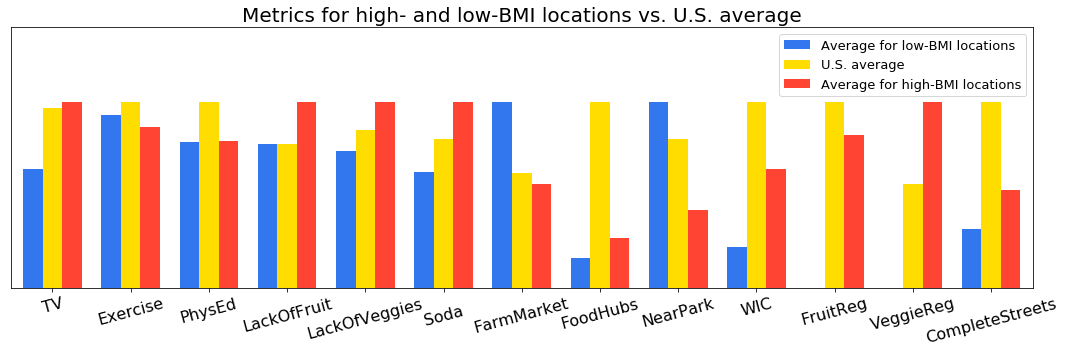

In [0]:
mean_values = pd.concat([lowest_BMI_mean_values, us_avg_values, highest_BMI_mean_values], axis=1)
mean_values.columns = ['LowBMI', 'avg', 'HighBMI']
lowest_BMI_normalized = mean_values.LowBMI/mean_values.max(axis=1)
avg_BMI_normalized = mean_values.avg/mean_values.max(axis=1)
highest_BMI_normalized = mean_values.HighBMI/mean_values.max(axis=1)

labels = mean_values_by_location.columns
labels.values[5] = '      Soda      '

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x-width, lowest_BMI_normalized, width, color = '#3377EE',
                label='Average for low-BMI locations')
rects2 = ax.bar(x, avg_BMI_normalized, width, color = '#FFDD00',
                label='U.S. average')
rects3 = ax.bar(x+width, highest_BMI_normalized, width, color = '#FF4433',
                label='Average for high-BMI locations')

ax.set_ylabel(' ')
ax.set_title('Metrics for high- and low-BMI locations vs. U.S. average')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15)
ax.get_yaxis().set_visible(False)
ax.set_ylim(top=1.4)
ax.legend(prop={'size': 13})

plt.margins(.0125)
plt.tight_layout()
plt.show()

For certain factors, the low-BMI average and high-BMI average are on opposite sides of the national average, suggesting a possible correlation between that factor and obesity rates. We can validate this analysis by calculating the Pearson correlation coefficient between all columns in our data and visualizing in a heat map.

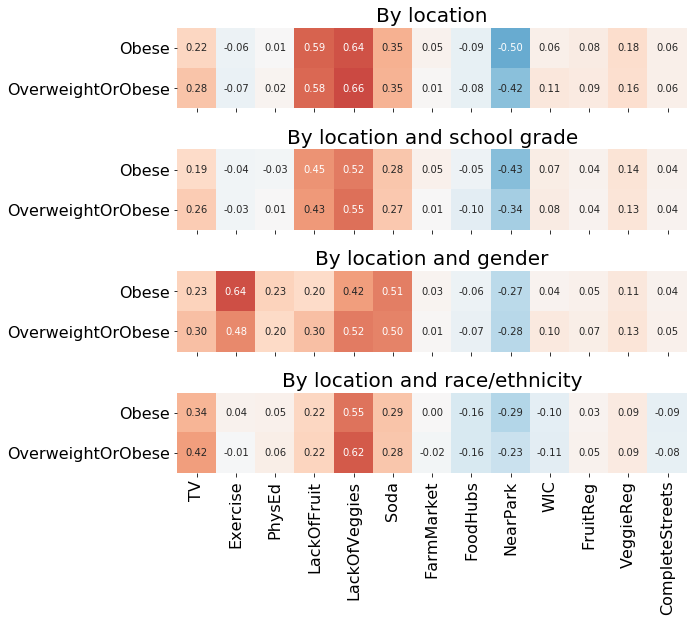

In [0]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(10,9))

ax1.set_title('By location')
df = obesity[~(obesity.Location == 'US') & (obesity.Group == 'Total')]
heatmap(df.corr().drop(columns=['Year','Obese','OverweightOrObese']
    ).loc[['Obese','OverweightOrObese']], vmin=-1, vmax=1, annot=True, fmt=".2f",
    cmap='RdBu_r', cbar=False, ax=ax1)

ax2.set_title('By location and school grade')
df = obesity[~(obesity.Location == 'US') & (obesity.Group.isin(grade_grouping))]
heatmap(df.corr().drop(columns=['Year','Obese','OverweightOrObese']
    ).loc[['Obese','OverweightOrObese']], vmin=-1, vmax=1, annot=True, fmt=".2f",
    cmap='RdBu_r', cbar=False, ax=ax2)

ax3.set_title('By location and gender')
df = obesity[~(obesity.Location == 'US') & (obesity.Group.isin(gender_grouping))]
heatmap(df.corr().drop(columns=['Year','Obese','OverweightOrObese']
    ).loc[['Obese','OverweightOrObese']], vmin=-1, vmax=1, annot=True, fmt=".2f",
    cmap='RdBu_r', cbar=False, ax=ax3)

ax4.set_title('By location and race/ethnicity')
df = obesity[~(obesity.Location == 'US') & (obesity.Group.isin(race_ethnicity_grouping))]
heatmap(df.corr().drop(columns=['Year','Obese','OverweightOrObese']
    ).loc[['Obese','OverweightOrObese']], vmin=-1, vmax=1, annot=True, fmt=".2f",
    cmap='RdBu_r', cbar=False, ax=ax4)

plt.setp(ax1.get_yticklabels(), rotation=0)
plt.setp(ax2.get_yticklabels(), rotation=0)
plt.setp(ax3.get_yticklabels(), rotation=0)
plt.setp(ax4.get_yticklabels(), rotation=0)
plt.tight_layout(2)
plt.show()

### Evaluation

Low-BMI locations have percentages lower than the national average of high-school students that "watch 3 or more hours of television each school day", "consume vegetables less than 1 time daily", and "drink regular soda/pop at least one time per day". Meanwhile, high-BMI locations have percentages higher than the national average for these same categories, as well as for students "consuming fruit less than 1 time daily".

Low-BMI locations also have more farmers markets per capita and more people living within half a mile of a park than the national average, while high-BMI locations have fewer of these than the national average. Interestingly, none of the low-BMI locations during any of the years in this data have "state child care regulations that align with national standards for serving fruits" or likewise for vegetables. High-BMI locations have these regulations for serving vegetables at rates higher than average, but not for fruits. Perhaps the high-BMI locations have attempted to address their obesity rates through regulations, while the low-BMI locations have not seen the need.

The correlation coefficients of factors mostly match what we saw in the bar chart. Watching TV, drinking soda, eating fruits less often, and especially eating vegetables less often are positively correlated with higher obesity rates across the statewide data, grade-grouped data, gender-grouped data, and race/ethnicity-grouped data. Living near a park is negatively correlated with higher obesity rates across these data groups. However, the numbers of farmers markets per capita and the prevalence of vegetable regulations do not appear strongly correlated, in contrast to the what the bar chart visualization implies.

These analyses highlight some of the nutritional, behavioral, institutional, and environmental factors that are most associated with obesity rates. However, it is important to remember that for the policy/environmental factors, we do not have population-specific data. In the correlation across location and race/ethnicity for example, we are looking at the correlation between obesity rates in different racial/ethnic groups across many locations versus the percent of all students in that location, regardless of racial/ethnic group, living within half a mile of a park. With more detailed data we would be able to further refine this analysis and consider more specific questions.

# Question 4: Can we predict obesity rates?

### Data Understanding

The correlation calculation we performed quantifies the degree to which there is a linear relationship between our metrics of interest and an associated risk factor. However, it does not take into account the other factors. To do that we can train a linear regression model on the data and see what factors are most important for model performance.

Let's take a look at the factors that will be in our model.

In [0]:
obesity.describe()[['TV','Exercise','PhysEd','LackOfFruit','LackOfVeggies',
    'Soda','FarmMarket','FoodHubs','NearPark','WIC','FruitReg','VeggieReg',
    'CompleteStreets']].loc[['min','max','std','count']]

,TV,Exercise,PhysEd,LackOfFruit,LackOfVeggies,Soda,FarmMarket,FoodHubs,NearPark,WIC,FruitReg,VeggieReg,CompleteStreets
min,7.800000,7.40000,0.000000,14.400000,13.500000,2.900000,0.200000,0.000000,14.400000,0.000000,0.000000,0.000000,0.000000
max,73.800000,67.40000,81.900000,59.500000,67.500000,51.200000,14.900000,212.000000,95.700000,83.300000,9.000000,4.000000,35.000000
std,10.072204,5.88483,12.480206,5.719986,6.969569,8.402084,2.543463,36.110206,19.819794,22.996295,1.392719,0.527447,5.433716
count,3466.000000,2483.00000,3326.000000,3435.000000,3144.000000,2567.000000,905.000000,455.000000,436.000000,455.000000,1828.000000,1828.000000,1371.000000


The factors vary in their ranges, but from the standard deviation we can see that none have only one value. Some have many missing values, which we will need to fill somehow.

### Data Preparation

Let's start with the data across all locations and drop the columns we don't want to be in the model.

In [0]:
df = obesity[~(obesity.Location == 'US') & (obesity.Group == 'Total')]
df.drop(columns=['Year','Location','Group','OverweightOrObese'], inplace=True)
df.head()

,TV,Exercise,PhysEd,LackOfFruit,LackOfVeggies,Soda,FarmMarket,FoodHubs,NearPark,WIC,FruitReg,VeggieReg,CompleteStreets,Obese
8,46.1,NaN,31.8,53.9,45.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.3
17,42.9,NaN,30.2,46.0,39.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.7
27,40.7,NaN,32.0,34.2,31.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.7
38,44.9,NaN,25.4,42.2,40.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1
47,24.1,NaN,30.4,40.1,32.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2


A common strategy to handle missing values is to impute (fill) them with a single value based on the statistics of that column. Let's use scikit-learn's **SimpleImputer** to do this with the mode (the most frequent value).

In [0]:
imp = impute.SimpleImputer(strategy='most_frequent')
df[df.columns] = imp.fit_transform(df[df.columns])
df.head()

,TV,Exercise,PhysEd,LackOfFruit,LackOfVeggies,Soda,FarmMarket,FoodHubs,NearPark,WIC,FruitReg,VeggieReg,CompleteStreets,Obese
8,46.1,25.4,31.8,53.9,45.9,18.2,1.6,2.0,14.4,0.0,0.0,0.0,1.0,12.3
17,42.9,25.4,30.2,46.0,39.2,18.2,1.6,2.0,14.4,0.0,0.0,0.0,1.0,13.7
27,40.7,25.4,32.0,34.2,31.7,18.2,1.6,2.0,14.4,0.0,0.0,0.0,1.0,10.7
38,44.9,25.4,25.4,42.2,40.8,18.2,1.6,2.0,14.4,0.0,0.0,0.0,1.0,10.1
47,24.1,25.4,30.4,40.1,32.2,18.2,1.6,2.0,14.4,0.0,0.0,0.0,1.0,7.2


### Modeling

Now we will split the data into a training set and a test set, build a linear regression model, train it, and use it to make predictions of obesity rates based on the data.

In [0]:
X = df.drop('Obese', axis=1)
y = df['Obese']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_test)

We can use the describe function from SciPy to look at the minimum and maximum of the training set and test set predictions. The percent of students that are obese can never be less than 0 or greater than 100. If any predictions fall outside these boundaries, or even if they are close, then linear regression could be a bad choice.

In [0]:
stats.describe(y_train_preds)[1]

(7.747373170843311, 17.959556265718824)

In [0]:
stats.describe(y_test_preds)[1]

(7.432411177000436, 18.45203789677136)

Not only are these percentages possible, they seem reasonable based on what we know about the data. Now we can quantify the accuracy of our model using the coefficient of determination between our predictions and the correct predictions.

In [0]:
r2_score(y_train, y_train_preds)

0.5350002085910034

In [0]:
r2_score(y_test, y_test_preds)

0.4844578297183506

Model accuracy is only 53.5% for the training set. So even when considering all factors at once and being given all the right answers, a linear model can only achieve so much. The data is far from perfectly correlated.

The model accuracy for the test set is 48.4%, not far behind the training score. The model is generalizing fairly well to new samples, despite both scores being lower than we might like.

Now let's look at which factors the model weights most heavily.

In [0]:
pd.DataFrame(index=X.columns, data=model.coef_, columns = ['coef']
             ).sort_values(by='coef', ascending=False)

,coef
VeggieReg,2.120486
FarmMarket,0.278491
FoodHubs,0.189022
LackOfFruit,0.172434
LackOfVeggies,0.123616
Soda,0.102210
FruitReg,0.089011
TV,0.047538
WIC,0.032109
NearPark,0.022892


Negative values indicate that the model predicts lower obesity when the factor value is high, while for positive coefficients it predicts higher rates. The absolute value of the coefficient represents the degree of influence of that factor on model predictions. Currently **VeggieReg** and **CompleteStreets** are being considered most heavily by the model. From the bar chart we saw that these factors, especially **VeggieReg**, seem to be correlated with geographic lcoation.

Will model performance improve if we consider geographic location? Rather than training the model on the specific state or territory, let's take a broader approach. We can use the four regions of the country defined by the [U.S. Census Bureau](https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf): Northeast, Midwest, South, and West. Territories are not classified in a region, so we will group them in a separate class.

In [0]:
west = ['AK', 'HI', 'WA', 'OR', 'CA', 'NV', 'ID', 'MT', 'WY', 'UT', 'CO', 'AZ', 'NM']
midwest = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH']
south = ['TX', 'OK', 'AR', 'LA', 'KY', 'TN', 'MS', 'AL', 'WV', 'MD', 'DE', 'DC', 'VA', 'NC', 'SC', 'GA', 'FL']
northeast = ['PA', 'NJ', 'NY', 'CT', 'RI', 'MA', 'VT', 'NH', 'ME']
territories = ['VI', 'GU', 'PR']

obesity['Region'] = obesity.Location.apply(
    lambda x: 'West' if x in west else 'Midwest' if x in midwest else 'South'
    if x in south else 'Northeast' if x in northeast else 'Territories'
    if x in territories else 'Other')
obesity = obesity[['Year', 'Location', 'Region', 'Group', 'TV', 'Exercise',
    'PhysEd', 'LackOfFruit', 'LackOfVeggies', 'Soda', 'FarmMarket', 'FoodHubs',
    'NearPark', 'WIC', 'FruitReg', 'VeggieReg', 'CompleteStreets', 'Obese',
    'OverweightOrObese']]
obesity.head()

,Year,Location,Region,Group,TV,Exercise,PhysEd,LackOfFruit,LackOfVeggies,Soda,FarmMarket,FoodHubs,NearPark,WIC,FruitReg,VeggieReg,CompleteStreets,Obese,OverweightOrObese
0,2001,AL,South,10th,51.7,NaN,26.1,54.0,47.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.8,28.3
1,2001,AL,South,11th,42.6,NaN,26.8,56.4,43.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1,22.6
2,2001,AL,South,12th,35.0,NaN,16.9,52.3,36.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.6,29.4
3,2001,AL,South,9th,51.3,NaN,50.6,52.7,52.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.1,28.4
4,2001,AL,South,Female,44.8,NaN,23.1,54.6,45.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.6,22.5


We'll process the data as before, but with an additional step: encoding our new categorical variable numerically.

In [0]:
df = obesity[~(obesity.Location == 'US') & (obesity.Group == 'Total')]
df.drop(columns=['Year','Location','Group','OverweightOrObese'], inplace=True)
df = pd.get_dummies(df, drop_first=True)
df.head()

,TV,Exercise,PhysEd,LackOfFruit,LackOfVeggies,Soda,FarmMarket,FoodHubs,NearPark,WIC,FruitReg,VeggieReg,CompleteStreets,Obese,Region_Northeast,Region_South,Region_Territories,Region_West
8,46.1,NaN,31.8,53.9,45.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.3,0,1,0,0
17,42.9,NaN,30.2,46.0,39.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.7,0,1,0,0
27,40.7,NaN,32.0,34.2,31.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.7,0,1,0,0
38,44.9,NaN,25.4,42.2,40.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1,0,1,0,0
47,24.1,NaN,30.4,40.1,32.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2,0,0,0,1


Now we have four columns of zeros and ones to tell us whether or not a location is in the Northeast, South, territories, or West. Zeros in all four columns mean that it is in the Midwest.

In [0]:
imp = impute.SimpleImputer(strategy='most_frequent')
df[df.columns] = imp.fit_transform(df[df.columns])
X = df.drop('Obese', axis=1)
y = df['Obese']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_test)
r2_score(y_train, y_train_preds)

0.6266046426683943

In [0]:
r2_score(y_test, y_test_preds)

0.5285004599973278

By simply telling the model to which of these five regions each sample belongs, model accuracy has improved. Let's zoom in on the location a bit more by providing the region subdivisions used by the Census Bureau.

In [0]:
NewEngland = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT']
MidAtlantic = ['NJ', 'NY', 'PA']
EastNorthCentral = ['IL', 'IN', 'MI', 'OH', 'WI']
WestNorthCentral = ['IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']
SouthAtlantic = ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV']
EastSouthCentral = ['AL', 'KY', 'MS', 'TN']
WestSouthCentral = ['AR', 'LA', 'OK', 'TX']
Mountain = ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY']
Pacific = ['AK', 'CA', 'HI', 'OR', 'WA']

obesity['Division'] = obesity.Location.apply(
    lambda x: 'NewEngland' if x in NewEngland else 'MidAtlantic'
    if x in MidAtlantic else 'EastNorthCentral' if x in EastNorthCentral else
    'WestNorthCentral' if x in WestNorthCentral else 'SouthAtlantic'
    if x in SouthAtlantic else 'EastSouthCentral' if x in EastSouthCentral else
    'WestSouthCentral' if x in WestSouthCentral else 'Mountain'
    if x in Mountain else 'Pacific' if x in Pacific else 'Territories'
    if x in territories else 'Other')
obesity = obesity[['Year', 'Location', 'Region', 'Division', 'Group', 'TV', 'Exercise',
    'PhysEd', 'LackOfFruit', 'LackOfVeggies', 'Soda', 'FarmMarket', 'FoodHubs',
    'NearPark', 'WIC', 'FruitReg', 'VeggieReg', 'CompleteStreets', 'Obese',
    'OverweightOrObese']]

df = obesity[~(obesity.Location == 'US') &
                         (obesity.Group == 'Total')]
df.drop(columns=['Year','Location','Group','OverweightOrObese'], inplace=True)
df = pd.get_dummies(df, drop_first=True)
imp = impute.SimpleImputer(strategy='most_frequent')
df[df.columns] = imp.fit_transform(df[df.columns])
X = df.drop('Obese', axis=1)
y = df['Obese']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_test)
r2_score(y_train, y_train_preds)

0.6735597371680366

In [0]:
r2_score(y_test, y_test_preds)

0.605933458955278

We've managed to get test accuracy above 60%; still not ideal for a useful predictive model. Let's consider some other algorithms.

In [0]:
def train_obesity_model(df, response_col, cols_to_drop, test_size, model_type):
    '''
    INPUT:
    df - pandas dataframe with obesity data or a subset thereof
    response_col - column of data to predict
    cols_to_drop - columns to drop and not train on
    test_size - proportion of the test-train split that is for testing, between 0 and 1
    model_type - choice of sklearn algorithm: 'LinearRegression', 'Lasso', 'Ridge',
        'ElasticNet', 'SVR', 'Bagging', 'RandomForest', 'AdaBoost'

    STEPS:
    Drop the rows with missing values for the response column
    Drop columns with all NaN values
    Drop the columns on which we do not want to train, such as the year, location, or other response column
    Split categorical variables using get_dummies()
    Impute missing values with the mode (most frequent value)
    Split into explanatory and response variables
    Split into training and test sets
    Build model
    Fit model to training data
    Predict the response variable for training and test sets
    Score the model on training and test sets

    OUTPUT:
    a pandas Series that contains the training score and test score
    '''
    
    # Drop the rows with missing response values
    df = df.dropna(subset=[response_col], axis=0)

    # Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    # Drop the columns on which we do not want to train, including the other response column
    df.drop(columns=cols_to_drop, inplace=True)

    # Get dummies
    df = pd.get_dummies(df, drop_first=True)

    # Impute missing values
    imp = impute.SimpleImputer(strategy='most_frequent')
    df[df.columns] = imp.fit_transform(df[df.columns])

    # Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Build model
    if model_type == 'LinearRegression':
      model = linear_model.LinearRegression()
    elif model_type == 'Lasso':
      model = linear_model.Lasso()
    elif model_type == 'Ridge':
      model = linear_model.Ridge()
    elif model_type == 'ElasticNet':
      model = linear_model.ElasticNet()
    elif model_type == 'SVR':
      model = svm.SVR(C=20)
    elif model_type == 'Bagging':
      model = ensemble.BaggingRegressor(random_state=0)
    elif model_type == 'RandomForest':
      model = ensemble.RandomForestRegressor(random_state=0)
    elif model_type == 'AdaBoost':
      model = ensemble.AdaBoostRegressor(random_state=0)

    # Fit model to training data
    model.fit(X_train, y_train)

    # Predict for training and test data
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)

    # Score model on training and test data
    training_score = r2_score(y_train, y_train_preds)
    test_score = r2_score(y_test, y_test_preds)

    # Return scores
    score = pd.Series({'training_score':training_score, 'test_score':test_score})

    return score

This function perfoms the steps of data preparation, model building, training, predicition, and scoring for five different choices of algorithm: linear regression, ridge regression, support vector regression (SVR), bagging, random forest, and AdaBoost. Ridge regression is a regularization technique that performs linear regression but with a penalties imposed on coefficients being too high. SVR is a regression extension of support vector machines, originally used in classification problems. Bagging, random forest, and AdaBoost are all ensemble techniques, in which multiple models are constructed and their predictions are integrated by some means into a single prediction. Let's build another function to plot the accuracy of these models on various subsets of the data.

In [0]:
def plot_alg_performance(df, cols_to_drop):
    '''
    INPUT:
    df - pandas dataframe with obesity data or a subset thereof
    cols_to_drop - columns to drop and not train on
    
    STEPS:
    Set up plot and labels
    Set response column to "Obese"
      Create dataframe to store model accuracy values
      For each data grouping (overall, by grade, by gender, by race/ethnicity) and
        each algorithm, call train_obesity_model() and store test set accuracy
      Plot test scores as bar chart
    Set response column to "OverweightOrObese"
      Create dataframe to store model accuracy values
      For each data grouping (overall, by grade, by gender, by race/ethnicity) and
        each algorithm, call train_obesity_model() and store test set accuracy
      Plot test scores as bar chart

    OUTPUT:
    None
    '''
    fig, axs = plt.subplots(2, 1, figsize=(15,9))
    labels = ['Overall', 'By school grade',
        'By gender', 'By race/ethnicity']
    x = np.arange(len(labels))
    width = 0.12

    # Plot obese results
    test_scores = pd.DataFrame({'LinearRegression':[0]*4, 'Lasso':[0]*4,
        'Ridge':[0]*4, 'ElasticNet':[0]*4, 'SVR':[0]*4, 'Bagging':[0]*4,
        'RandomForest':[0]*4, 'AdaBoost':[0]*4}, index=[
        '["Total"]', 'grade_grouping', 'gender_grouping',
        'race_ethnicity_grouping'])
    cols_to_drop_obese = cols_to_drop.copy()
    cols_to_drop_obese.append('OverweightOrObese')
    for grouping in test_scores.index:
      df_grouping = eval('df[~(df.Location == "US") & (df.Group.isin('+grouping+'))]')
      for model_type in test_scores.columns:
        score = train_obesity_model(df_grouping, 'Obese', cols_to_drop_obese,
            test_size=.3, model_type = model_type)
        test_scores.loc[grouping, model_type] = score.test_score
    rects0 = axs[0].bar(x-2.5*width, test_scores['LinearRegression'], width, color = '#3377EE',
                        label='Linear regression')
    rects1 = axs[0].bar(x-1.5*width, test_scores['Ridge'], width, color = '#FFDD00',
                        label='Ridge regression')
    rects2 = axs[0].bar(x-.5*width, test_scores['SVR'], width, color = '#FF4433',
                        label='SVR')
    rects3 = axs[0].bar(x+.5*width, test_scores['Bagging'], width, color = '#55DD55',
                        label='Bagging')
    rects4 = axs[0].bar(x+1.5*width, test_scores['RandomForest'], width, color = '#CC55CC',
                        label='Random forest')
    rects5 = axs[0].bar(x+2.5*width, test_scores['AdaBoost'], width, color = '#AAAAAA',
                        label='AdaBoost')
    axs[0].annotate('Max test score: '+str(round(test_scores.max().max(), 2)),
                    (1.25, 1.05*test_scores.max().max()), fontsize=16)
    axs[0].axhline(y=test_scores.max().max(), xmin=0, xmax=6, linestyle='--', c='r')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(labels)
    axs[0].set_ylim((0,1))
    axs[0].legend(loc='upper right', ncol=2)
    axs[0].set_title('Test score for predicting the percent of students obese')

    # Plot overweight or obese results
    test_scores = pd.DataFrame({'LinearRegression':[0]*4, 'Lasso':[0]*4,
        'Ridge':[0]*4, 'ElasticNet':[0]*4, 'SVR':[0]*4, 'Bagging':[0]*4,
        'RandomForest':[0]*4, 'AdaBoost':[0]*4}, index=[
        '["Total"]', 'grade_grouping', 'gender_grouping',
        'race_ethnicity_grouping'])
    cols_to_drop_ovr_or_obese = cols_to_drop.copy()
    cols_to_drop_ovr_or_obese.append('Obese')
    for grouping in test_scores.index:
      df_grouping = eval('df[~(df.Location == "US") & (df.Group.isin('+grouping+'))]')
      for model_type in test_scores.columns:
        score = train_obesity_model(df_grouping, 'OverweightOrObese', cols_to_drop_ovr_or_obese,
            test_size=.3, model_type = model_type)
        test_scores.loc[grouping, model_type] = score.test_score
    rects0 = axs[1].bar(x-2.5*width, test_scores['LinearRegression'], width, color = '#3377EE',
                        label='Linear regression')
    rects1 = axs[1].bar(x-1.5*width, test_scores['Ridge'], width, color = '#FFDD00',
                        label='Ridge regression')
    rects2 = axs[1].bar(x-.5*width, test_scores['SVR'], width, color = '#FF4433',
                        label='SVR')
    rects3 = axs[1].bar(x+.5*width, test_scores['Bagging'], width, color = '#55DD55',
                        label='Bagging')
    rects4 = axs[1].bar(x+1.5*width, test_scores['RandomForest'], width, color = '#CC55CC',
                        label='Random forest')
    rects5 = axs[1].bar(x+2.5*width, test_scores['AdaBoost'], width, color = '#AAAAAA',
                        label='AdaBoost')
    axs[1].annotate('Max accuracy: '+str(round(test_scores.max().max(), 2)),
                    (1.25, 1.05*test_scores.max().max()), fontsize=16)
    axs[1].axhline(y=test_scores.max().max(), xmin=0, xmax=6, linestyle='--', c='r')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(labels)
    axs[1].set_ylim((0,1))
    axs[1].legend(loc='upper right', ncol=2)
    axs[1].set_title('Test score for predicting the percent of students overweight or obese')

    plt.tight_layout(2.5)
    plt.show()

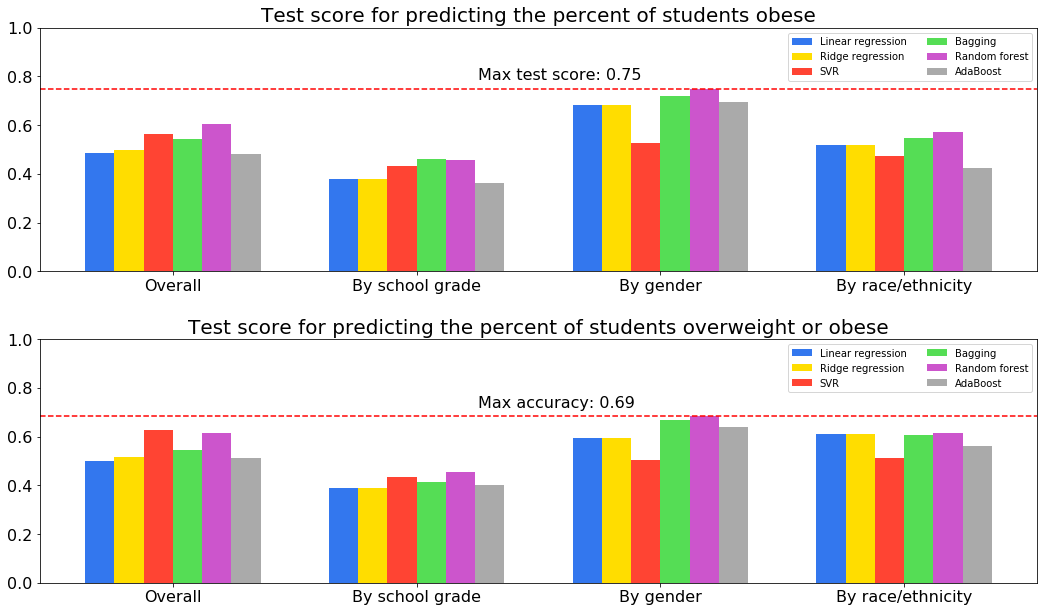

In [0]:
plot_alg_performance(obesity, cols_to_drop = ['Year','Location','Region','Division'])

For both the percent of students obese and those overweight or obese, SVR, bagging, and random forest outperform the other algorithms. We can also see that predictive performance is better across all algorithms for the overall data by location. This may be because there are simply more data samples, which allow for more training, more learning, and thus higher accuracy when generalizing to the test samples.

Let's see how geographic location impacts model performance.

In [0]:
plot_alg_performance(obesity, cols_to_drop = ['Year','Region','Division'])

Model accuracy improves when we train on the specific location (state or territory). What about the more coarse-grained region and division?

In [0]:
plot_alg_performance(obesity, cols_to_drop = ['Year','Location','Division'])

In [0]:
plot_alg_performance(obesity, cols_to_drop = ['Year','Location','Region'])

By considering just the region or division, model accuracy improves relative to performance without any consideration of geography, but not as high as when state-level information is given.

### Evaluation

Recalling the trends explored in Question 1, each of the three population groupings had a different degree of overlap, hinting at the amount of information provided.

Obesity rates by school grade were highly overlapping, with no one group having consistently higher or lower values. Thus, the variability was higher than for the overall data without an easy way to differentiate the groups. Here we see worse performance of models trained on data grouped by grade.

In contrast, gender provides very meaningful information for predicting obesity rates. Variability in the health outcomes is again higher relative to overall data, but we can differentiate the higher and lower values based on gender. Accordingly, model accuracies are improved relative to those trained on the overall data.

The race/ethnicity grouping is somewhere in between these two cases. Some trends cross often while others are more separable and predictable. The Asian obesity rates are the lowest always, while the Non-Hispanic White rates never cross over those of the major population groups (those with larger sample sizes). Model performance, too, is in between that of the grade- and gender-grouped cases, falling near that of the overall data.

The impact of geographic information on the models is small but consistent, increasing accuracy by about 7% in the best case. Regional and sub-regional geography can achieve about half of this improvement in accuracy.

While model performance is somewhat lacking overall, failing to crack 80% accuracy in most cases, we have an understanding of how it is governed by the choice of training data and model features.

# Summary Evaluation

In examining this data we have seen that the percents of high-school students in the United States that are obese and those that are overweight or obese have increased from 2001 to 2017, are higher in certain racial/ethnic groups, and are higher in males than females, although females are catching up. We have also learned that five states in the Rocky Mountains have the lowest obesity rates, and in those states students tend to watch less TV, eat more vegetables, and drink less non-diet soda than the national average. Those states also have more farmers markets per capita and more people living within half a mile of a park than the national average. Five states along the Mississippi River and Guam have the highest obesity rates, and students in those locations tend to watch more TV, eat fewer fruits and vegetables, and drink more non-diet soda than the national average. Those locations also have fewer farmers markets per capita and fewer people living within half a mile of a park than the national average. Similar results are seen in the single-factor correlation coefficients. We have also shown that by providing some level of information on geographic location, the test set accuracy of a model can be improved.

One important caveat is that BMI is not the same as body fat percentage, nor is it perfectly correlated. The metric has been criticized for its bias across height ranges (being underpredicted for shorter individuals and overpredicted for taller) and failure to account for body composition properties, such as a person's degree of musculature.

Another is that much of the data considered here are from self-report surveys, including a student's height and weight, which are used to calculate BMI. The [YRBSS methodology documentation](https://www.cdc.gov/mmwr/pdf/rr/rr6201.pdf) mentions a CDC study on the reliability of these two question in particular, in which students' heights and weights were measured after having taken the questionnaire: "Self-reported height, weight, and BMI calculated from these values were substantially reliable, but on average, students in the study overreported their height by 2.7 inches and underreported their weight by 3.5 pounds, which indicates that YRBSS probably underestimates the prevalence of overweight and obesity in adolescent populations." In addition, the policy data comes from aggregating various state and local level reports under a common standard, for example that the "state has adopted some form of a Complete Streets policy".

Finally, the factors considered here are far from the only ones that could be used to understand and predict rates of youth obesity. The documentation states that the "CDC decided that the system should focus almost exclusively on health-risk behaviors rather than on the determinants of these behaviors (e.g., knowledge, attitudes, beliefs, and skills), because there is a more direct connection between specific health-risk behaviors and specific health outcomes than between determinants of behaviors and health outcomes." However, research and analysis of the determining factors of risk behaviors is undoubtedly important in the effort to address this issue.

# Deployment

This project presents a preliminary analysis of the risk factors associated with youth obesity in the United States. It points to gender, geography, television watching, vegetable and soda consumption, and proximity to farmers markets and parks as particularly correlated. Factors such as exercise, physical education, and state regulations were not seen to be strongly correlated. Gender and geography are not actionable interventions that policy makers or companies can implement. Furthermore, it is unclear to what degree the other factors act as proxies for geography, and whether they could be used to positively impact obesity rates. Based on these insights alone, I would recommend American children eat more vegetables, drink less or no soda, and watch less television.